In [1]:
#ИМПОРТ И ФУНКЦИИ С КЛАССАМИ
import os
import glob
import h5py
import torch
import random
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from IPython.display import Audio, display
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import tqdm

# выбираем устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#класс датасета
class AudioDataset(Dataset):
    def __init__(self, h5_path):
        self.h5_path = h5_path
        self.file = h5py.File(h5_path, 'r')
        
        self.spectrograms = self.file['spectrograms']
        self.labels = self.file['labels']
        self.class_names = [name.decode('utf-8') for name in self.file.attrs['class_names']]
        self.num_classes = self.file.attrs['num_classes']
        
        print(f"Loaded {len(self.spectrograms)} samples from HDF5")
    
    def __len__(self):
        return len(self.spectrograms)
    
    def __getitem__(self, idx):
        # Загружаем непосредственно из HDF5
        spectrogram = torch.tensor(self.spectrograms[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return spectrogram, label
    
    def __del__(self):
        if hasattr(self, 'file'):
            self.file.close()
    
    def get_class_names(self):
        return self.class_names 
#функция потерь (для теста)
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return focal_loss.mean()
#CNN + classifier    
class AudioCNN(nn.Module):
    def __init__(self, num_classes, input_channels=1):
        
        super(AudioCNN, self).__init__()
        
        # CNN
        self.conv_layers = nn.Sequential(
            
            # Блок 1
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),    #[16, 64, 64]
            nn.Dropout(0.15),
            
            # Блок 2
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),    #[32, 32, 32]
            nn.Dropout(0.2),
            
            # Блок 3 
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),    #[64, 16, 16]
            nn.Dropout(0.25),

            # Блок 4
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.AdaptiveAvgPool2d((4,4)),    #[128, 4, 4]
        )

        # FC
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x
    
#полносвязная
class SimpleFCModel(nn.Module):
    def __init__(self, num_classes: int, input_height: int, input_width: int, hidden_size: int = 256):
        super(SimpleFCModel, self).__init__()
        
        self.input_height = input_height
        self.input_width = input_width
        self.num_classes = num_classes
        
        # Вычисляем размер после вытягивания в вектор
        self.flatten_size = input_height * input_width
        
        self.layers = nn.Sequential(
            # Вытягиваем в плоский вектор
            nn.Flatten(),
            
            # Первый скрытый слой
            nn.Linear(self.flatten_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),  # для регуляризации
            
            # Второй скрытый слой (можно добавить больше)
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(), 
            nn.Dropout(0.4),
            
            # Выходной слой
            nn.Linear(hidden_size // 2, num_classes)
        )
    
    def forward(self, x):
        x = self.layers(x)
        return x
#метрики
def calculate_all_metrics(y_true, y_pred, loss, threshold):
    
    metrics = {}
    # Loss
    metrics['loss'] = loss
    # F1 Macro - баланс между классами (ОСНОВНАЯ)
    metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    # Precision Macro - контроль false positive
    metrics['precision_macro'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    # Recall Macro - контроль false negative
    metrics['recall_macro'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    # Threshold - порог опредления label'а
    metrics['threshold'] = threshold

    # F1 для каждого класса
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
    metrics['f1_per_class'] = f1_per_class
    
    return metrics

def train_epoch(model, loader, optimizer, criterion, epoch, num_epochs, threshold):
    model.train()
    all_targets = []
    all_predictions = []
    all_loss = 0.0
    output = []
    
    # Создаем прогресс-бар
    pbar = tqdm.tqdm(loader, desc=f'Epoch {epoch}/{num_epochs}', 
                bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}')
    
    for data, targets in pbar:
        data = data.to(device)
        targets = targets.to(device)   
        optimizer.zero_grad()                          
        outputs = model(data)                          
        loss = criterion(outputs, targets)             
        all_loss += loss.item()

        loss.backward()                                
        optimizer.step()                                 
        
        # Сохраняем предсказания и цели для метрик
        with torch.no_grad():            
            probs = torch.sigmoid(outputs)           
            predictions = (probs > threshold).float()            
            all_targets.append(targets.cpu())           
            all_predictions.append(predictions.cpu())
            
        # Обновляем прогресс-бар
        current_loss = all_loss / (pbar.n + 1)
        pbar.set_postfix({'Loss': f'{current_loss:.4f}'})

    all_targets = torch.cat(all_targets).numpy()
    all_predictions = torch.cat(all_predictions).numpy()
    all_loss /= len(loader)

    return calculate_all_metrics(all_targets, all_predictions, all_loss, threshold)

def evaluate_epoch(model, loader, criterion, threshold, auto_threshold):
    model.eval()
    all_targets = []
    all_predictions = []
    all_probs = []
    all_loss = 0.0
    
    with torch.no_grad():
        for data, targets in loader:  
            data = data.to(device)
            targets = targets.to(device) 
            outputs = model(data)                       
            loss = criterion(outputs, targets)
            all_loss += loss.item()
            
            probs = torch.sigmoid(outputs)   
            predictions = (probs > threshold).float()   
            
            all_targets.append(targets.cpu())          
            all_predictions.append(predictions.cpu())
            all_probs.append(probs.cpu())
    
    all_targets = torch.cat(all_targets).numpy()
    all_predictions = torch.cat(all_predictions).numpy()
    all_probs = torch.cat(all_probs)
    all_loss /= len(loader)

    best_threshold = threshold
    best_f1 = 0.0
    
    # расчёт лучшего порога
    if auto_threshold:
        for threshold in torch.arange(0.05, 0.9, 0.05):
            predictions = (all_probs > threshold).float()
            f1 = f1_score(all_targets, predictions, average='macro')
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold.item()

    return calculate_all_metrics(all_targets, all_predictions, all_loss, best_threshold)

def train_model(model, train_loader, val_loader, optimizer, criterion, patience=10,
                num_epochs=50, threshold=0.5, save_dir='../data/models', 
                start_epoch=1, history=None, best_f1=0.0, auto_threshold=False):
    
    os.makedirs(save_dir, exist_ok=True)

    # Инициализация истории, если не передана
    if history is None:
        history = {
            'train_loss': [], 'val_loss': [],
            'train_f1': [], 'val_f1': [],
            'train_precision': [], 'val_precision': [],
            'train_recall': [], 'val_recall': [],
            'train_threshold': [], 'val_threshold': [],
            'epochs_completed': 0,
            'total_epochs': num_epochs,
            'best_f1': 0.0,
            'f1_per_class':[]
        }
    
    patience_counter = 0

    for epoch in range(start_epoch, start_epoch + num_epochs):
        # Обучение и валидация
        train_metrics = train_epoch(model, train_loader, optimizer, criterion, epoch, start_epoch + num_epochs - 1, threshold)
        val_metrics = evaluate_epoch(model, val_loader, criterion, threshold, auto_threshold)
        
        # Сохраняем историю
        history['train_loss'].append(train_metrics['loss'])
        history['val_loss'].append(val_metrics['loss'])
        history['train_f1'].append(train_metrics['f1_macro'])
        history['val_f1'].append(val_metrics['f1_macro'])
        history['train_precision'].append(train_metrics['precision_macro'])
        history['val_precision'].append(val_metrics['precision_macro'])
        history['train_recall'].append(train_metrics['recall_macro'])
        history['val_recall'].append(val_metrics['recall_macro'])
        history['epochs_completed'] = epoch
        history['best_f1'] = max(history.get('best_f1', 0.0), val_metrics['f1_macro'])
        history['f1_per_class'] = val_metrics['f1_per_class']

        # Выводим метрики
        print("─" * 50)
        print(f"Epoch {epoch}/{start_epoch + num_epochs - 1}")
        print(f"Train >>> Loss: {train_metrics['loss']:.4f} | F1: {train_metrics['f1_macro']:.4f} | "
              f"Precision: {train_metrics['precision_macro']:.4f} | Recall: {train_metrics['recall_macro']:.4f} | "
              f"Threshold: {threshold:.2f}")

        print(f"Val   >>> Loss: {val_metrics['loss']:.4f} | F1: {val_metrics['f1_macro']:.4f} | "
              f"Precision: {val_metrics['precision_macro']:.4f} | Recall: {val_metrics['recall_macro']:.4f} | "
              f"Threshold: {threshold:.2f}")

        # обновляем threshold
        threshold = val_metrics['threshold'] 

        # Early stopping и сохранение лучшей модели
        if val_metrics['f1_macro'] > best_f1:
            best_f1 = val_metrics['f1_macro']
            # Сохраняем полное состояние для продолжения обучения
            history_copy = history.copy()
            history_copy.pop('f1_per_class')
            checkpoint = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history_copy,
                'epoch': epoch,
                'best_f1': best_f1,
                'patience_counter': patience_counter,
                'threshold': threshold
            }
            torch.save(checkpoint, f'{save_dir}/best_model.pth')
            patience_counter = 0
            print(f"Новая лучшая модель сохранена! F1: {best_f1:.4f}")
        else:
            patience_counter += 1
            print(f"Нет улучшений: ({patience_counter}/{patience})")
            
        if patience_counter >= patience:
            print(f"Ранняя остановка на эпохе {epoch}.")
            break

        # Сохраняем последнюю модель каждые N эпох
        if epoch % 5 == 0:
            checkpoint = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history,
                'epoch': epoch,
                'best_f1': best_f1,
                'patience_counter': patience_counter,
                'threshold': threshold
            }
            torch.save(checkpoint, f'{save_dir}/checkpoint_epoch_{epoch}.pth')

        print("\n")

    # Финальное сохранение
    final_checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history,
        'epoch': epoch,
        'best_f1': best_f1,
        'patience_counter': patience_counter,
        'threshold': threshold
    }
    torch.save(final_checkpoint, f'{save_dir}/last_model.pth')

    return history, best_f1

def load_checkpoint(model, optimizer, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    history = checkpoint['history']
    start_epoch = checkpoint['epoch'] + 1
    best_f1 = checkpoint['best_f1']
    threshold = checkpoint.get('threshold', 0.5)
    
    print(f"Загружен чекпоинт эпохи {checkpoint['epoch']}")
    print(f"Лучший F1: {best_f1:.4f}")
    print(f"Всего эпох в истории: {len(history['train_loss'])} \n")
    
    return model, optimizer, history, start_epoch, best_f1, threshold

def plot_training_history(history, save_path=None):
    
    fig = plt.figure(figsize=(15, 14))
    fig.suptitle('История тренировки', fontsize=16, fontweight='bold')
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    gs = plt.GridSpec(3, 2, figure=fig)

    # 1. Loss
    ax1 = fig.add_subplot(gs[0,0])
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. F1 Score
    ax2 = fig.add_subplot(gs[0,1])
    ax2.plot(epochs, history['train_f1'], 'b-', label='Train F1', linewidth=2)
    ax2.plot(epochs, history['val_f1'], 'r-', label='Val F1', linewidth=2)
    ax2.set_title('F1 Macro Score')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Precision
    ax3 = fig.add_subplot(gs[1,0])
    ax3.plot(epochs, history['train_precision'], 'b-', label='Train Precision', linewidth=2)
    ax3.plot(epochs, history['val_precision'], 'r-', label='Val Precision', linewidth=2)
    ax3.set_title('Precision Macro')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Precision')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Recall
    ax4 = fig.add_subplot(gs[1,1])
    ax4.plot(epochs, history['train_recall'], 'b-', label='Train Recall', linewidth=2)
    ax4.plot(epochs, history['val_recall'], 'r-', label='Val Recall', linewidth=2)
    ax4.set_title('Recall Macro')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Recall')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Гистограмма F1 по классам (нижняя строка на всю ширину)
    ax5 = fig.add_subplot(gs[2, :])
    
    if history['f1_per_class'] is not None:
        f1_scores = history['f1_per_class']
        n_classes = len(f1_scores)
        x = np.arange(n_classes)
        
        # Минималистичная гистограмма
        bars = ax5.bar(x, f1_scores, alpha=0.7, color='lightblue', edgecolor='navy', linewidth=0.5)
        
        # Настройки гистограммы
        ax5.set_title('F1-score по классам (последняя эпоха)', fontsize=12, pad=10)
        ax5.set_xlabel('Классы')
        ax5.set_ylabel('F1-score')
        ax5.set_ylim(0, 1.0)
        ax5.grid(True, alpha=0.3)
        
        # Подписи классов
        ax5.set_xticks(x)
        ax5.set_xticklabels([f'{i}' for i in range(n_classes)], rotation=45 if n_classes > 30 else 0, fontsize=8)
        
        # Линия среднего значения
        mean_f1 = np.mean(f1_scores)
        ax5.axhline(y=mean_f1, color='red', linestyle='--', alpha=0.8, 
                   label=f'Средний F1: {mean_f1:.3f}')
        ax5.legend()
        
        # Добавляем значения на столбцы для лучших классов (топ-5)
        if len(f1_scores) > 0:
            # Находим индексы топ-5 классов по F1
            top_indices = np.argsort(f1_scores)[-5:][::-1]
            for idx in top_indices:
                if f1_scores[idx] > 0:
                    ax5.text(idx, f1_scores[idx] + 0.02, f'{f1_scores[idx]:.2f}', 
                            ha='center', va='bottom', fontsize=7, fontweight='bold')
    else:
        ax5.text(0.5, 0.5, 'F1 по классам недоступен', 
                ha='center', va='center', transform=ax5.transAxes, fontsize=12)
        ax5.set_title('F1-score по классам')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Graphs saved to: {save_path}")
    
    plt.show()

def calculate_pos_weight(dataset, max_weight=3.0, smoothing=1.0, beta=0.999):
    all_targets = []
    for i in range(len(dataset)):
        _, targets = dataset[i]
        all_targets.append(targets)

    all_targets = torch.stack(all_targets)
    
    positive_counts = all_targets.sum(dim=0) + smoothing
    negative_counts = (all_targets.size(0) - all_targets.sum(dim=0)) + smoothing

    # print(f"Позитивные: {positive_counts}")

    pos_weight = negative_counts / positive_counts

    pos_weight = torch.sqrt(pos_weight)
    pos_weight = pos_weight / pos_weight.min()


    # pos_weight = torch.log1p(pos_weight)
    # pos_weight = pos_weight / pos_weight.mean()

    print(f"Коррекция весов: {pos_weight} \n")

    return pos_weight.to(device)



In [2]:
# ЗАГРУЗКА ДАТАСЕТА
# ----------------------------------------------------------
tags_dict = {}
# открываем подготовленный словрь
with open("../data/track_tags.pkl", 'rb') as file:
    tags_dict = pickle.load(file)

# загружаем датасет
dataset = AudioDataset("../data/128x128.h5")



# разбиваем датасет на train и test
dataset_size = len(dataset)
indices = list(range(dataset_size))

train_idx, test_idx = train_test_split(
    indices, 
    test_size = 0.3,
    train_size = 0.7,       
    random_state = 42        # для воспроизводимости
)

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,  
    num_workers=8,   
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,  
    num_workers=4,   
    pin_memory=True,
    persistent_workers=False,
    prefetch_factor=2
)

for data, targets in train_loader:
    print(f"DATA - shape: {data.shape}")
    print(f"       min: {data.min().item():.4f}, max: {data.max().item():.4f}")
    print(f"       mean: {data.mean().item():.4f}, std: {data.std().item():.4f}")
    print(f"target exemple: {targets[0]}")
    break

Loaded 184860 samples from HDF5
DATA - shape: torch.Size([32, 1, 128, 128])
       min: -13.8155, max: 11.9327
       mean: 1.1111, std: 3.8096
target exemple: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.])


Используется устройство: cuda
Количество параметров модели: 2258331

Коррекция весов: tensor([2.0911, 1.9909, 1.6143, 1.9641, 1.8896, 2.3130, 1.9707, 1.9729, 1.6801,
        2.0380, 2.6741, 1.7000, 1.1899, 1.6636, 1.6957, 2.0478, 2.3753, 1.3474,
        1.1548, 1.1148, 1.3248, 3.8968, 1.0552, 1.9217, 2.9772, 2.6217, 3.0462,
        1.0000, 3.4004, 3.1997, 2.8853, 3.3786, 1.4060, 1.3798, 1.5344, 2.0070,
        3.4225, 1.1841, 1.6636, 2.0755, 2.6319, 2.5966, 1.8105, 2.7471, 1.1179,
        2.9058, 1.6746, 1.5269, 3.8483, 2.0164, 1.9533, 1.9217, 1.8761, 2.4553,
        1.8722, 2.5770, 3.2466, 2.0001, 1.5899]) 

Загружен чекпоинт эпохи 45
Лучший F1: 0.5103
Всего эпох в истории: 45 



Epoch 46/145: 100%|████████████████████| 4044/4044 [00:48<00:00, 82.57it/s, Loss=0.1155]


──────────────────────────────────────────────────
Epoch 46/145
Train >>> Loss: 0.1154 | F1: 0.5346 | Precision: 0.4458 | Recall: 0.6717 | Threshold: 0.15
Val   >>> Loss: 0.1403 | F1: 0.5090 | Precision: 0.5277 | Recall: 0.5155 | Threshold: 0.15
Нет улучшений: (1/10)




Epoch 47/145: 100%|████████████████████| 4044/4044 [00:48<00:00, 83.46it/s, Loss=0.1140]


──────────────────────────────────────────────────
Epoch 47/145
Train >>> Loss: 0.1138 | F1: 0.5402 | Precision: 0.4485 | Recall: 0.6826 | Threshold: 0.15
Val   >>> Loss: 0.1383 | F1: 0.5139 | Precision: 0.5340 | Recall: 0.5220 | Threshold: 0.15
Новая лучшая модель сохранена! F1: 0.5139




Epoch 48/145: 100%|████████████████████| 4044/4044 [00:48<00:00, 83.07it/s, Loss=0.1134]


──────────────────────────────────────────────────
Epoch 48/145
Train >>> Loss: 0.1132 | F1: 0.5424 | Precision: 0.4497 | Recall: 0.6871 | Threshold: 0.15
Val   >>> Loss: 0.1388 | F1: 0.5143 | Precision: 0.5347 | Recall: 0.5201 | Threshold: 0.15
Новая лучшая модель сохранена! F1: 0.5143




Epoch 49/145: 100%|████████████████████| 4044/4044 [00:48<00:00, 82.85it/s, Loss=0.1127]


──────────────────────────────────────────────────
Epoch 49/145
Train >>> Loss: 0.1125 | F1: 0.5447 | Precision: 0.4520 | Recall: 0.6892 | Threshold: 0.15
Val   >>> Loss: 0.1406 | F1: 0.5118 | Precision: 0.5394 | Recall: 0.5133 | Threshold: 0.15
Нет улучшений: (1/10)




Epoch 50/145: 100%|████████████████████| 4044/4044 [00:48<00:00, 83.24it/s, Loss=0.1123]


──────────────────────────────────────────────────
Epoch 50/145
Train >>> Loss: 0.1121 | F1: 0.5458 | Precision: 0.4527 | Recall: 0.6912 | Threshold: 0.15
Val   >>> Loss: 0.1367 | F1: 0.5147 | Precision: 0.5274 | Recall: 0.5298 | Threshold: 0.15
Новая лучшая модель сохранена! F1: 0.5147




Epoch 51/145: 100%|████████████████████| 4044/4044 [00:48<00:00, 83.61it/s, Loss=0.1116]


──────────────────────────────────────────────────
Epoch 51/145
Train >>> Loss: 0.1115 | F1: 0.5490 | Precision: 0.4552 | Recall: 0.6953 | Threshold: 0.15
Val   >>> Loss: 0.1368 | F1: 0.5231 | Precision: 0.5453 | Recall: 0.5269 | Threshold: 0.15
Новая лучшая модель сохранена! F1: 0.5231




Epoch 52/145: 100%|████████████████████| 4044/4044 [00:48<00:00, 83.19it/s, Loss=0.1114]


──────────────────────────────────────────────────
Epoch 52/145
Train >>> Loss: 0.1112 | F1: 0.5500 | Precision: 0.4561 | Recall: 0.6964 | Threshold: 0.15
Val   >>> Loss: 0.1395 | F1: 0.5116 | Precision: 0.5393 | Recall: 0.5140 | Threshold: 0.15
Нет улучшений: (1/10)




Epoch 53/145: 100%|████████████████████| 4044/4044 [00:48<00:00, 83.36it/s, Loss=0.1110]


──────────────────────────────────────────────────
Epoch 53/145
Train >>> Loss: 0.1110 | F1: 0.5502 | Precision: 0.4564 | Recall: 0.6965 | Threshold: 0.15
Val   >>> Loss: 0.1377 | F1: 0.5221 | Precision: 0.5438 | Recall: 0.5273 | Threshold: 0.15
Нет улучшений: (2/10)




Epoch 54/145: 100%|████████████████████| 4044/4044 [00:48<00:00, 83.35it/s, Loss=0.1112]


──────────────────────────────────────────────────
Epoch 54/145
Train >>> Loss: 0.1110 | F1: 0.5487 | Precision: 0.4541 | Recall: 0.6967 | Threshold: 0.15
Val   >>> Loss: 0.1382 | F1: 0.5138 | Precision: 0.5372 | Recall: 0.5207 | Threshold: 0.15
Нет улучшений: (3/10)




Epoch 55/145: 100%|████████████████████| 4044/4044 [00:48<00:00, 83.29it/s, Loss=0.1103]


──────────────────────────────────────────────────
Epoch 55/145
Train >>> Loss: 0.1101 | F1: 0.5542 | Precision: 0.4595 | Recall: 0.7019 | Threshold: 0.15
Val   >>> Loss: 0.1362 | F1: 0.5247 | Precision: 0.5438 | Recall: 0.5337 | Threshold: 0.15
Новая лучшая модель сохранена! F1: 0.5247




Epoch 56/145: 100%|████████████████████| 4044/4044 [00:48<00:00, 83.17it/s, Loss=0.1102]


──────────────────────────────────────────────────
Epoch 56/145
Train >>> Loss: 0.1100 | F1: 0.5535 | Precision: 0.4588 | Recall: 0.7015 | Threshold: 0.15
Val   >>> Loss: 0.1404 | F1: 0.5150 | Precision: 0.5477 | Recall: 0.5149 | Threshold: 0.15
Нет улучшений: (1/10)




Epoch 57/145: 100%|████████████████████| 4044/4044 [00:48<00:00, 83.37it/s, Loss=0.1098]


──────────────────────────────────────────────────
Epoch 57/145
Train >>> Loss: 0.1096 | F1: 0.5554 | Precision: 0.4605 | Recall: 0.7039 | Threshold: 0.15
Val   >>> Loss: 0.1426 | F1: 0.5089 | Precision: 0.5438 | Recall: 0.5079 | Threshold: 0.15
Нет улучшений: (2/10)




Epoch 58/145: 100%|████████████████████| 4044/4044 [00:48<00:00, 83.61it/s, Loss=0.1095]


──────────────────────────────────────────────────
Epoch 58/145
Train >>> Loss: 0.1094 | F1: 0.5574 | Precision: 0.4626 | Recall: 0.7053 | Threshold: 0.15
Val   >>> Loss: 0.1390 | F1: 0.5135 | Precision: 0.5408 | Recall: 0.5160 | Threshold: 0.15
Нет улучшений: (3/10)




Epoch 59/145: 100%|████████████████████| 4044/4044 [00:48<00:00, 83.22it/s, Loss=0.1094]


──────────────────────────────────────────────────
Epoch 59/145
Train >>> Loss: 0.1092 | F1: 0.5557 | Precision: 0.4602 | Recall: 0.7049 | Threshold: 0.15
Val   >>> Loss: 0.1379 | F1: 0.5165 | Precision: 0.5399 | Recall: 0.5240 | Threshold: 0.15
Нет улучшений: (4/10)




Epoch 60/145: 100%|████████████████████| 4044/4044 [00:48<00:00, 83.47it/s, Loss=0.1097]


──────────────────────────────────────────────────
Epoch 60/145
Train >>> Loss: 0.1095 | F1: 0.5551 | Precision: 0.4603 | Recall: 0.7032 | Threshold: 0.15
Val   >>> Loss: 0.1382 | F1: 0.5204 | Precision: 0.5502 | Recall: 0.5201 | Threshold: 0.15
Нет улучшений: (5/10)




Epoch 61/145: 100%|████████████████████| 4044/4044 [00:48<00:00, 82.87it/s, Loss=0.1089]


──────────────────────────────────────────────────
Epoch 61/145
Train >>> Loss: 0.1087 | F1: 0.5575 | Precision: 0.4622 | Recall: 0.7064 | Threshold: 0.15
Val   >>> Loss: 0.1384 | F1: 0.5160 | Precision: 0.5370 | Recall: 0.5263 | Threshold: 0.15
Нет улучшений: (6/10)




Epoch 62/145: 100%|████████████████████| 4044/4044 [00:48<00:00, 83.02it/s, Loss=0.1090]


──────────────────────────────────────────────────
Epoch 62/145
Train >>> Loss: 0.1088 | F1: 0.5579 | Precision: 0.4628 | Recall: 0.7065 | Threshold: 0.15
Val   >>> Loss: 0.1390 | F1: 0.5128 | Precision: 0.5350 | Recall: 0.5195 | Threshold: 0.15
Нет улучшений: (7/10)




Epoch 63/145: 100%|████████████████████| 4044/4044 [00:48<00:00, 82.84it/s, Loss=0.1088]


──────────────────────────────────────────────────
Epoch 63/145
Train >>> Loss: 0.1086 | F1: 0.5587 | Precision: 0.4631 | Recall: 0.7080 | Threshold: 0.15
Val   >>> Loss: 0.1404 | F1: 0.5137 | Precision: 0.5384 | Recall: 0.5198 | Threshold: 0.15
Нет улучшений: (8/10)




Epoch 64/145: 100%|████████████████████| 4044/4044 [00:48<00:00, 82.78it/s, Loss=0.1084]


──────────────────────────────────────────────────
Epoch 64/145
Train >>> Loss: 0.1082 | F1: 0.5594 | Precision: 0.4637 | Recall: 0.7089 | Threshold: 0.15
Val   >>> Loss: 0.1391 | F1: 0.5215 | Precision: 0.5539 | Recall: 0.5192 | Threshold: 0.15
Нет улучшений: (9/10)




Epoch 65/145: 100%|████████████████████| 4044/4044 [00:48<00:00, 83.21it/s, Loss=0.1082]


──────────────────────────────────────────────────
Epoch 65/145
Train >>> Loss: 0.1081 | F1: 0.5612 | Precision: 0.4654 | Recall: 0.7107 | Threshold: 0.15
Val   >>> Loss: 0.1379 | F1: 0.5215 | Precision: 0.5419 | Recall: 0.5268 | Threshold: 0.15
Нет улучшений: (10/10)
Ранняя остановка на эпохе 65.


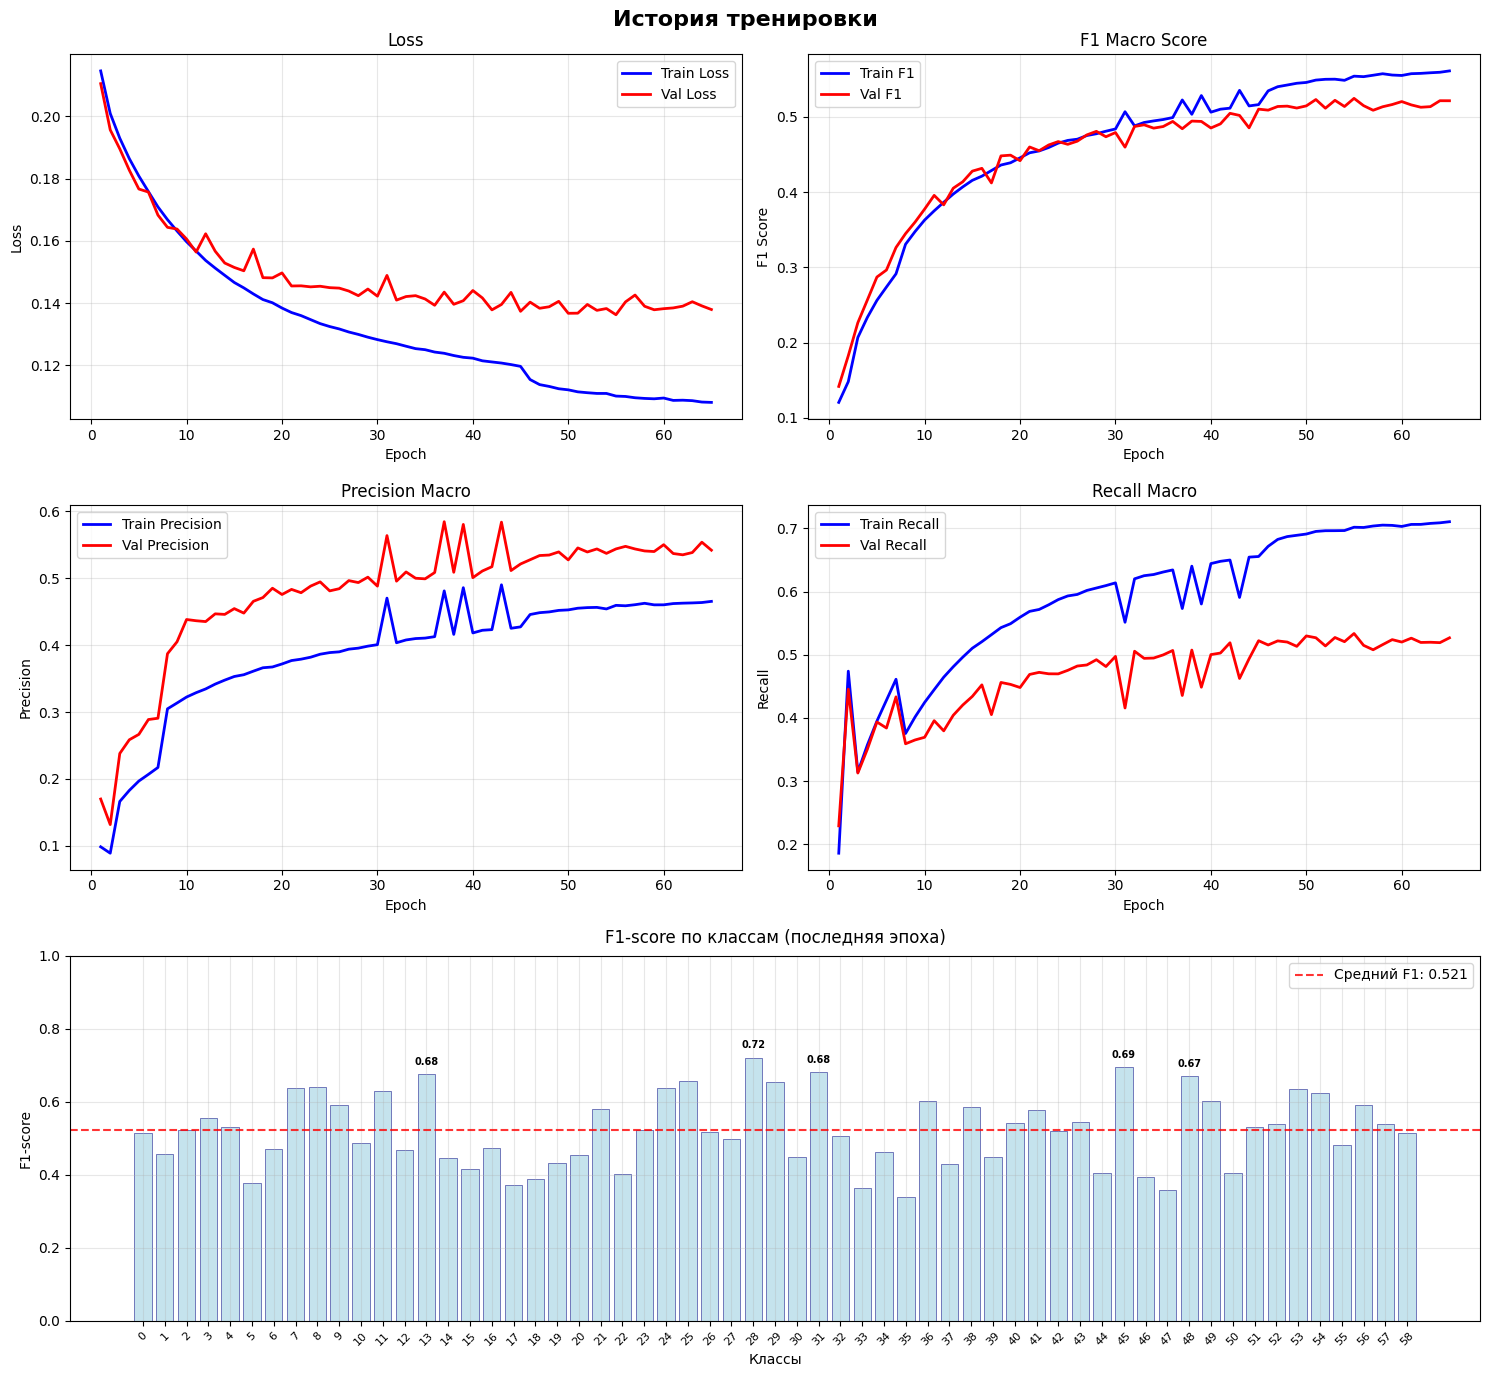

=== MULTI-LABEL DEBUG ===
Outputs range: [-34.318, 6.122]
Probabilities range: [0.000, 0.998]
Sample 0 predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample 0 targets:     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample 0 matched:     1 correct positive tags
Batch accuracy: 0.985
Positive tag accuracy: 0.844
=== MODEL DEBUG ===
Input data range: [-13.816, 12.043]
Input data mean: 0.722
Model outputs range: [-46.872, 7.648]
Model outputs mean: -9.339
Gradient conv_layers.0.weight: 0.008981
Gradient conv_layers.0.bias: 0.000000
Gradient conv_layers.1.weight: 0.006082
Gradient conv_layers.1.bias: 0.004297
Gradient conv_layers.5.weight: 0.000441
Gradient conv_layers.5.bias: 0.000000
Gradient conv_layers.6.we

In [3]:
#ОБУЧЕНИЕ МОДЕЛИ
def debug_model_predictions(model, loader, threshold=0.5):
    model.eval()
    
    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > threshold).float()  # ⚡ Multi-hot вектор!
            
            print("=== MULTI-LABEL DEBUG ===")
            print(f"Outputs range: [{outputs.min():.3f}, {outputs.max():.3f}]")
            print(f"Probabilities range: [{probabilities.min():.3f}, {probabilities.max():.3f}]")
            
            # Правильная интерпретация
            print(f"Sample 0 predictions: {predictions[0].cpu().numpy()}")
            print(f"Sample 0 targets:     {targets[0].cpu().numpy()}")
            print(f"Sample 0 matched:     {((predictions[0] == targets[0]) & (targets[0] == 1)).sum().item()} correct positive tags")
            
            # Статистика по батчу
            batch_accuracy = ((predictions == targets).float().mean().item())
            positive_accuracy = ((predictions[targets == 1] == 1).float().mean().item())
            
            print(f"Batch accuracy: {batch_accuracy:.3f}")
            print(f"Positive tag accuracy: {positive_accuracy:.3f}")
            break
def debug_model_outputs(model, data_loader):
    model.eval()
    
    with torch.no_grad():
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            
            print("=== MODEL DEBUG ===")
            print(f"Input data range: [{data.min():.3f}, {data.max():.3f}]")
            print(f"Input data mean: {data.mean():.3f}")
            
            # Проверяем выходы каждого слоя
            print(f"Model outputs range: [{outputs.min():.3f}, {outputs.max():.3f}]")
            print(f"Model outputs mean: {outputs.mean():.3f}")
            
            # Проверяем градиенты
            for name, param in model.named_parameters():
                if param.requires_grad and param.grad is not None:
                    print(f"Gradient {name}: {param.grad.abs().mean():.6f}")
                else:
                    print(f"Gradient {name}: None")
            
            break
def debug_model_weights():
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name:30} mean: {param.data.mean().item():8.4f} std: {param.data.std().item():8.4f}")
        elif 'bias' in name:
            print(f"{name:30} mean: {param.data.mean().item():8.4f}")
 
num_epochs = 100        # количество эпох для обучения
threshold = 0.1         # порог для предсказаний
patience = 10           # остановка обучения после N эпох без улучшений

start_epoch = 1         #
history = None          # "Зашлушка" для переменных если надо будет загрузить недообученную модель
best_f1 = 0.0           #

# Инициализация модели
model = AudioCNN(dataset.num_classes)
model.to(device)

print(f"Используется устройство: {device}")
print(f"Количество параметров модели: {sum(p.numel() for p in model.parameters())}\n")

#заменил FocalLoss, на BCEWithLogitsLoss
# criterion = FocalLoss(1, 2)
# criterion = nn.MultiLabelSoftMarginLoss(calculate_pos_weight(dataset))
pos_weight = calculate_pos_weight(dataset)
criterion = nn.BCEWithLogitsLoss(pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-3)

# Загрузка модели
model, optimizer, history, start_epoch, best_f1, threshold = load_checkpoint(model, optimizer, "../data/models/best_model.pth", device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
threshold = 0.15

# Запуск обучения
history, best_f1 = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=num_epochs,
    threshold = threshold,
    save_dir='../data/models',
    patience=patience,
    start_epoch=start_epoch,
    history=history,
    best_f1=best_f1,
    auto_threshold = False
)

# вывод графиков
plot_training_history(history)

debug_model_predictions(model, train_loader, threshold)
debug_model_outputs(model, train_loader)

In [4]:
import torchaudio 

def random_audio_predictor(model, preprocess_function, class_names, folder_path='../data/train/', device='cuda', threshold=0.5):
    """
    Случайный выбор аудио файла с автовоспроизведением и предсказанием тегов
    """
    
    print("🎲 СЛУЧАЙНЫЙ АУДИО АНАЛИЗ")
    print("=" * 50)
    
    # Находим все аудио файлы в папке
    audio_extensions = ['*.wav', '*.mp3', '*.flac', '*.m4a', '*.ogg']
    audio_files = []
    
    for ext in audio_extensions:
        # Ищем файлы в основной папке и подпапках
        audio_files.extend(glob.glob(os.path.join(folder_path, '**', ext), recursive=True))
        audio_files.extend(glob.glob(os.path.join(folder_path, ext)))
    
    if not audio_files:
        print(f"❌ В папке {folder_path} не найдено аудио файлов!")
        return None
    
    # print(f"📁 Папка: {folder_path}")
    # print(f"📊 Найдено файлов: {len(audio_files)}")
    # print(f"🎚️  Порог: {threshold}")
    
    # Выбираем случайный файл
    selected_file = random.choice(audio_files)
    filename = os.path.basename(selected_file)
    file_path = os.path.dirname(selected_file)
    
    # print(f"\n🎯 Выбран файл: {filename}")
    # print(f"📂 Путь: {file_path}")
    # print("─" * 50)
    

    # Автовоспроизведение аудио
    print("🔊 Автовоспроизведение...")
    display(Audio(selected_file, autoplay=True))
        
    # Предсказание тегов
    print("\n🤖 Анализ тегов...")
    probs, active_tags = quick_predict(
        model=model,
        audio_path=selected_file,
        preprocess_function=preprocess_function,
        class_names=class_names,
        device=device,
        threshold=threshold
    )
    
    if probs is not None:
        # Выводим результаты
        print(f"\n🏷️  ПРЕДСКАЗАННЫЕ ТЕГИ:")
        print("─" * 30)
        
        if active_tags:
            print(f"✅ Найдено тегов: {len(active_tags)}")
            print("\n📋 Список тегов:")
            for tag in active_tags:
                prob = probs[class_names.index(tag)]
                print(f"   • {tag}: {prob:.3f}")
        else:
            print("❌ Нет тегов выше порога")
        
        # # Топ-10 всех предсказаний
        # top_indices = np.argsort(probs)[::-1][:10]
        # print(f"\n🔝 Топ-10 всех предсказаний:")
        # for i, idx in enumerate(top_indices, 1):
        #     prob = probs[idx]
        #     tag = class_names[idx]
        #     marker = "✅" if prob > threshold else "  "
        #     print(f"   {i:2d}. {marker} {tag:<25} {prob:.3f}")
        
        new_dict = {}
        for key, vals in tags_dict.items():
            new_dict[key[3:]] = vals

        print(f"Правильные теги: {new_dict.get(filename, "none")}")

        # Статистика
        print(f"\n📊 СТАТИСТИКА:")
        print(f"   Всего возможных тегов: {len(class_names)}")
        print(f"   Активных тегов: {len(active_tags)}")
        print(f"   Максимальная вероятность: {max(probs):.3f}")
        print(f"   Средняя вероятность: {np.mean(probs):.3f}")
            
        return {
            'file': selected_file,
            'filename': filename,
            'probs': probs,
            'active_tags': active_tags,
            'threshold': threshold
        }           

def preprocess_audio(audio_path, target_sr = 22050, noise = False, start=4096, size=128) -> torch.Tensor:
    waveform, sr = torchaudio.load(audio_path, normalize=True, channels_first=True)
    #уменьшил частоту дискретизации, чтобы ещё меньше датасет весил, а то везде 44100 Гц или почти везде
    if sr != target_sr:
        waveform = torchaudio.functional.resample(waveform, sr, target_sr)
    
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=22050,
        n_mels=128,        
        n_fft=2048,       
        hop_length=512,
        f_min=20,
        f_max=11025
    )(waveform)

    mel_spectrogram = torch.log(mel_spectrogram + 1e-6)

    # добавим немного шума (это скорее всего сильно замедлит подготовку данных)
    if noise:
        for x in mel_spectrogram:
            x += random.uniform(-1.0, 1.0)

    return mel_spectrogram[0,:,:size]

def quick_predict(model, audio_path, preprocess_function, class_names, device='cuda', threshold=0.5):
    """
    Функция предсказания тегов для аудио файла
    """
    model.to(device)
    model.eval()
    
    try:
        # Препроцессинг
        mel_spec = preprocess_function(audio_path)
        
        # Добавляем batch dimension и перемещаем на устройство
        if len(mel_spec.shape) == 3:  # [channels, height, width]
            input_tensor = mel_spec.unsqueeze(0)  # [1, channels, height, width]
        else:
            input_tensor = mel_spec.unsqueeze(0).unsqueeze(0)  # [1, 1, height, width]
        
        input_tensor = input_tensor.to(device)
        
        # Предсказание
        with torch.no_grad():
            outputs = model(input_tensor)
            probs = torch.sigmoid(outputs).cpu().numpy()[0]
        
        # Собираем активные теги
        active_tags = []
        for i, (class_name, prob) in enumerate(zip(class_names, probs)):
            if prob > threshold:
                active_tags.append(class_name)
        
        return probs, active_tags
        
    except Exception as e:
        print(f"❌ Ошибка во время предсказания: {e}")
        return None, None

best_model = AudioCNN(dataset.num_classes)
best_model,_,_,_,_,threshold = load_checkpoint(best_model, optimizer, "../data/models/best_model.pth", device)
best_model.to(device)
best_model.eval()

# Простой вызов - один случайный файл
random_audio_predictor(
    model=best_model,
    preprocess_function=preprocess_audio,
    class_names=dataset.get_class_names(),
    folder_path='../data/train', #'/home/egr/Музыка',  # Ваша папка с аудио
    device=device,
    threshold=0.15  # Можно настроить порог
)


Загружен чекпоинт эпохи 55
Лучший F1: 0.5247
Всего эпох в истории: 55 

🎲 СЛУЧАЙНЫЙ АУДИО АНАЛИЗ
🔊 Автовоспроизведение...



🤖 Анализ тегов...

🏷️  ПРЕДСКАЗАННЫЕ ТЕГИ:
──────────────────────────────
✅ Найдено тегов: 3

📋 Список тегов:
   • dream: 0.176
   • emotional: 0.246
   • film: 0.366
Правильные теги: {'film', 'emotional'}

📊 СТАТИСТИКА:
   Всего возможных тегов: 59
   Активных тегов: 3
   Максимальная вероятность: 0.366
   Средняя вероятность: 0.022


/home/egr/projects/nmus/.venv/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/egr/projects/nmus/.venv/lib/python3.12/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3

{'file': '../data/train/18/1049718.mp3',
 'filename': '1049718.mp3',
 'probs': array([6.31714799e-03, 1.10667199e-03, 1.82170246e-03, 4.73507866e-03,
        3.94800998e-04, 3.34876007e-04, 3.69969103e-03, 5.62710268e-03,
        2.25381274e-03, 2.87612893e-05, 5.67328942e-04, 4.58396180e-03,
        3.24643566e-03, 7.19265256e-04, 1.29188430e-02, 3.56458053e-02,
        3.79682658e-03, 1.75914720e-01, 2.46299669e-01, 2.89289677e-03,
        1.04269739e-02, 5.07095976e-10, 3.65699172e-01, 5.45868602e-07,
        5.01294228e-10, 1.26755740e-02, 2.99396191e-07, 5.79876220e-03,
        5.51180490e-11, 1.58723087e-05, 2.53323669e-04, 3.13573255e-05,
        1.10335220e-02, 1.50430948e-02, 5.15455604e-02, 3.69588062e-02,
        1.92117250e-06, 3.92627791e-02, 2.63829774e-04, 1.22011593e-02,
        1.65058838e-04, 1.01059406e-07, 1.15083283e-04, 2.66441275e-05,
        3.47101949e-02, 5.79440496e-07, 2.10083439e-03, 1.41972482e-01,
        2.15591722e-09, 8.19915906e-03, 1.73709355e-02, 9.